In [1]:
NAME = "Matthew A. Hernandez"
# University of Arizona email address
EMAIL = "mah8@arizona.edu"
# Names of any collaborators.  Write N/A if none.
COLLABORATORS = "N/A"

## Class Competition
Description, Evaluation, and Data Set taken from the [class competition site](https://www.kaggle.com/competitions/ling-539-sp-2024-class-competition) and [GitHub blog](https://uazhlt-ms-program.github.io/ling-539-course-blog/assignments/class-competition).

## Description
Marvin works at the last Blockbusta Videoz (a fictional video rental shop) where his task is to classify movie and TV show reviews to help curate a special section of the store.

One day while perusing his favorite website, Marvin came upon a post about someone who secretly automated their job and then quietly took off on a long (paid) vacation. Inspired, Marvin set aside a portion of his salary to hire a developer to write a few scripts to scrape movie reviews from various sources. It's a bit noisy, but aggregating many reviews has cut the time he previously spent on his job by half.

Now, after reading an article about AI, Marvin wants to take things a step further: he is searching for a program that can determine a) whether or not a piece of text is a movie/TV show review and b) whether or not each review is positive (the movie/TV show is recommended) or negative (the movie/TV show should be avoided).

Marvin has put together a competition and advertised it on Fraggle (a fictional platform for competitive data science).

## Evaluation

The evaluation metric for this competition is the macro F1 score (i.e., the unweighted mean F1). The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision *P* and recall *R*.

Precision is the ratio of true positives *TP* to all the predicted positions *TP+FP*. Recall is the ratio of true positives *TP* to all the actual positives *TP+FN*. The F1 score is given by:


$$
F1 = 2\frac{P*R}{P+R}, Precision = \frac{TP}{TP+FP}, Recall = \frac{TP}{TP+FN}
$$


The F1 metric weighs recall and precision equally. Moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

## Data Set

| **FILE NAME**         | **AVAILABLE FORMATS**       | 
|-----------------------|-----------------------------|
|  train                | .csv (64.9 MB)              | 
|  test                 | .csv (15.9 MB)              |
|  sample_submission    | .csv (?? kb)                |


| **COLUMN** | **DESCRIPTION**                         | 
|------------|-----------------------------------------| 
|  ID        | Unique ID for this datapoint            |
|  TEXT      | The text of the document                | 
|  LABEL     | The label for the datapoint (see below) |

| **LABEL** | **DESCRIPTION**                       | 
|-----------|---------------------------------------|
|  0        | Not a movie or TV show review         | 
|  1        | A positive movie or TV show review    |
|  2        | A negative movie or TV show review    |

## 1. Setup and Imports

In [96]:
# Utilities
import pandas as pd
import numpy as np
import pickle
import re

# Plotting
import matplotlib.pyplot as plt

# ML/NLP libaries
from nltk import word_tokenize, sent_tokenize
from nltk import PorterStemmer
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Paths
train_file_path = "../data/train.csv"
test_file_path = "../data/test.csv"

## 2. Explore the data

In [3]:
def read_reviews(reviews_path):
    '''
    Reads a CSV file and returns a dataframe.
    
    @param reviews_path:
    @return: pd.DataFrame
    '''
    df = pd.read_csv(reviews_path)
    return df

df_train = read_reviews(train_file_path)
df_test = read_reviews(test_file_path)
df_train.head()

,ID,TEXT,LABEL
0,7850790573542594519,If you love good films don't ever buy this pei...,2
1,9392069522632994700,The 33 percent of the nations nitwits that sti...,2
2,5083704536542443514,I saw Anatomy years ago -- dubbed at a friends...,1
3,12418349755186772171,Dark Remains is a home run plain and simple. T...,1
4,12144957944004619479,Feh. This movie started out in an interesting ...,2


In [4]:
print(f"Dataframe shape: {df_train.shape[0]}")
print(f"Dataframe types: \n{df_train.dtypes}")

Dataframe shape: 70317
Dataframe types: 
ID       uint64
TEXT     object
LABEL     int64
dtype: object


In [5]:
df_test['ID'][0]

4728459160322025755

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70317 entries, 0 to 70316
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70317 non-null  uint64
 1   TEXT    70311 non-null  object
 2   LABEL   70317 non-null  int64 
dtypes: int64(1), object(1), uint64(1)
memory usage: 1.6+ MB


Text column is missing 6 values. The shape of the dataframe is 70317. The data set is relatively clean, so no additional preprocessing is needed.

In [7]:
df_train['TEXT'].fillna(value='Unknown', inplace=True)

**Drop missing values.** Other option would be to replace the Text columns with an 'Unknown' value.

In [8]:
# verify the changes were made
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70317 entries, 0 to 70316
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70317 non-null  uint64
 1   TEXT    70317 non-null  object
 2   LABEL   70317 non-null  int64 
dtypes: int64(1), object(1), uint64(1)
memory usage: 1.6+ MB


In [9]:
df_train.describe()

,ID,LABEL
count,7.031700e+04,70317.000000
mean,9.237206e+18,0.813687
std,5.341639e+18,0.831365
min,5.764730e+14,0.000000
25%,4.592511e+18,0.000000
50%,9.273194e+18,1.000000
75%,1.387591e+19,2.000000
max,1.844662e+19,2.000000


In [10]:
df_test.head()

,ID,TEXT
0,4728459160322025755,An excellent debut movie for the the director ...
1,1840432070229003467,If you have a preschooler or remember how stre...
2,12623336783082722606,What should have been a routine babysitting gi...
3,7446733850828603409,Cute but
4,16180660281866613068,"Elvis Presley plays a ""half-breed"" Native Amer..."


In [11]:
print(f"Dataframe shape: {df_test.shape[0]}")
print(f"Dataframe types: \n{df_test.dtypes}")

Dataframe shape: 17580
Dataframe types: 
ID      uint64
TEXT    object
dtype: object


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17580 entries, 0 to 17579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      17580 non-null  uint64
 1   TEXT    17579 non-null  object
dtypes: object(1), uint64(1)
memory usage: 274.8+ KB


In [13]:
df_test['TEXT'].fillna(value='Unknown', inplace=True)

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17580 entries, 0 to 17579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      17580 non-null  uint64
 1   TEXT    17580 non-null  object
dtypes: object(1), uint64(1)
memory usage: 274.8+ KB


### 2.1 Let's take a look at our data distribution:

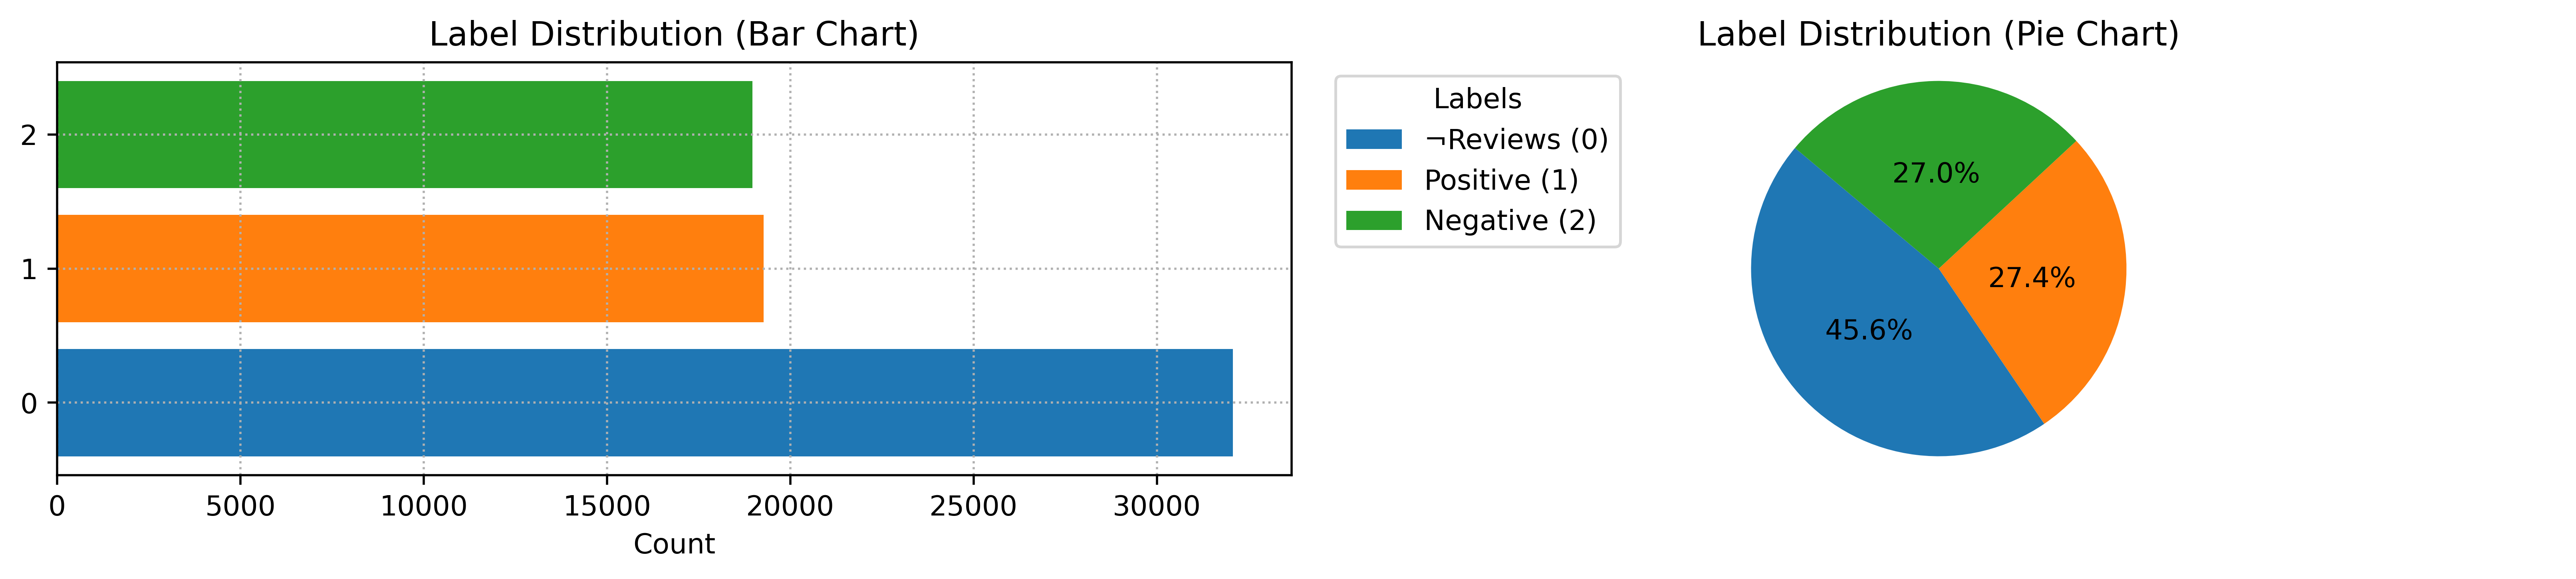

LABEL
0    32071
1    19276
2    18970
Name: count, dtype: int64


In [15]:
# Define figure and subplots
labels = ["¬Reviews (0)","Positive (1)", "Negative (2)"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3), dpi=500)
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Plotting the bar chart for label distribution
label_counts = df_train['LABEL'].value_counts()
ax1.barh(label_counts.index, label_counts, alpha=1.0,color=colors)
ax1.set_xlabel('Count')
ax1.set_title('Label Distribution (Bar Chart)')
ax1.grid(True, linestyle='dotted')
ax1.set_yticks(np.arange(len(label_counts)))

# Plotting the pie chart for label distribution

ax2.pie(label_counts, autopct='%1.1f%%', pctdistance=0.50,startangle=140,colors=colors)
ax2.set_title('Label Distribution (Pie Chart)')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax2.legend(labels,
          title='Labels',
          loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
print(df_train['LABEL'].value_counts())

**Notes:** Consider *resampling techniques* to handle the skewed data.

### 2.2 Let's take a deeper look:

In [16]:
# Consider the word count of each review 
df_train['WORD_COUNT'] = df_train['TEXT'].apply(word_tokenize)
df_train['WORD_COUNT'] = df_train['WORD_COUNT'].apply(len)

In [17]:
df_train.head()

,ID,TEXT,LABEL,WORD_COUNT
0,7850790573542594519,If you love good films don't ever buy this pei...,2,14
1,9392069522632994700,The 33 percent of the nations nitwits that sti...,2,233
2,5083704536542443514,I saw Anatomy years ago -- dubbed at a friends...,1,146
3,12418349755186772171,Dark Remains is a home run plain and simple. T...,1,152
4,12144957944004619479,Feh. This movie started out in an interesting ...,2,409


In [18]:
df_train['WORD_COUNT'].max()

6839

**Notes:** Remember to handle HTML tags &#x2713; , character escape sequences &#x2713;, en dashes &#x2713;, large proportion of non reviews, accents, epsilon, consider not case folding, emoticons, difference languages, etc...

## 3. Preprocessing Data
- Convert text to numerical features for your machine learning model

### Word2Vec Preprocessing

In [365]:
# words will need this for the Word2Vec model
def vocabulary(review, remove_stopwords=False, stemmer=False):
    clean_review = BeautifulSoup(review).get_text() # removes html tags
    clean_review = re.sub(r'[^a-zA-Z]', ' ', clean_review)
    clean_review = re.sub(r'\.{2,}', ' ellipsis ', clean_review)
    clean_review = re.sub(r'!!+', 'exclaim', clean_review)
    vocab = clean_review.lower().split()
    
    # optionally add stemmer
    
    return (vocab)

In [367]:
global_sentences = []
print("Adding sentences from the training data...")
for review in training_texts:
    global_sentences += review_2_sents(review, sent_tokenize)

Adding sentences from the training data...


/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_12128/421762148.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_review = BeautifulSoup(review).get_text() # removes html tags
/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_12128/421762148.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  clean_review = BeautifulSoup(review).get_text() # removes html tags


In [366]:
# Word2Vec implementation requires sentences
def review_2_sents(review, tokenizer):
    temp_sents = tokenizer(review)
    sentences = []
    for temp_sent in temp_sents:
        sentences.append(vocabulary(temp_sent))
    return sentences

### Playground

In [ ]:
# t2f = TextToFeatures()
# t2f.preprocess_text(training_texts[10014])

In [260]:
training_texts[10016]

"This is unlike other Kurasawa films and therefore less known in the west.  In his other films, Kurasawa uses camera angles, settings , motion and music to grab the viewer and immerse him into the movie.  In &quot;Tiger's Tail &quot; there is very little camera work or settings-In fact, I remember only three:the forest,The checkpoint and The Road.  This movie instead draws all its power and intensity by using Kabuki styled acting and motion. <p> The story is about a prince who is being hunted by his bitrailling brother.  To escape, he relize on the help of a handful of loyal samurai as they covertley try to pass a main check point even though all enemy warriors are on high alert. This is why the movie is also called &quot;They who step on tiger's Tail.<p> I loved the acting of the lead General who is disguessed as a Yamabushi(Priest Samurai).  If you wanted to see Kabuki or understand one of the elements that set Kurasawa's style apart from other Directors, then see this movie.  I'm bu

In [257]:
# preprocess_text(training_texts[10014])

'Buy this set for the game not the movie. it s like buying a game a getting a bad movie as bonus content *HAPPY EMOTICON'

### Regular Preprocessing

In [158]:
class TextToFeatures():
    def __init__(self):
        '''
        Initializes an object for converting texts to features
        '''
        self.vectorizer = CountVectorizer(lowercase=False, preprocessor=self.preprocess_text, tokenizer=self.nltk_tokenizer,\
                                         token_pattern=None, ngram_range=(1,3), binary=False)
#         self.vectorizer = TfidfVectorizer(lowercase=False, preprocessor=self.preprocess_text, tokenizer=word_tokenize,\
#                                          token_pattern=None, ngram_range=(1,3), binary=False)
        self.stemmer = PorterStemmer()
#         self.stopwords = set(stopwords.words('English'))
    
    def spacy_tokenizer(self, document):
        return [word.text for word in nlp(document)]
        
    def nltk_tokenizer(self, document):
        return word_tokenize(document)
        
    def preprocess_text(self, document):
        '''
        Use RegEx to preprocess text.
        
        @param document: text reviews
        @return: processed text
        '''  
        clean_review = document
        clean_review = BeautifulSoup(clean_review).get_text()
#         clean_review = re.sub(r'<br /><br />?', ' ', clean_review)
        clean_review = re.sub(r'\x86', '-', clean_review)
        clean_review = re.sub(r'\x96', '<UNKNOWN> ', clean_review)
        clean_review = re.sub(r'\n+', ' ', clean_review)
        clean_review = re.sub(r"\'", " ", clean_review)
        clean_review = re.sub(r'\.{2,}', ' <ELLIPSIS> ', clean_review)
        clean_review = re.sub(r'!!+', ' <EXCLAIM>', clean_review)
        clean_review = re.sub(r':-D', '<HAPPY EMOTICON>', clean_review)
        clean_review = re.sub(r':-D', ' <HAPPY EMOTICON>', clean_review)
        clean_review =re.sub(r'HIGHLY RECOMMENDED.', '<HIGHLY RECOMMENDED>', clean_review)
        

#         clean_review = re.sub(r'""') double quotes
        ## hasMeh: bool hasWorth
        
        tokenized_review = clean_review.split()
        stemmed_review = [self.stemmer.stem(w) for w in tokenized_review]
        processed_review = ' '.join(stemmed_review)
        return processed_review

#         return clean_review
           
    def fit(self, training_texts):
        '''
        Fits ("trains") a TextToFeature instance on a collection of documents.
        
        The provided training texts are analyzed to determine the vocabulary, 
        i.e., all feature values that the converter will support. 
        Each such feature value will be associated with a unique integer index 
        that may later be accessed via the .index() method.
        '''
        self.vectorizer.fit(training_texts)
        
    def index(self, feature):
        '''
        Returns the index in the vocabulary of the given feature value.  
        If the features isn't present, return None.

        @param feature: feature
        @return: unique integer index associated with the feature or None if not present.
        '''
        terms = self.vectorizer.vocabulary_
        index = terms.get(feature, None)
        return index
        
    def transform(self, texts):
        '''
        Creates a feature matrix from a sequence of texts.
        
        @param :
        @return : 
        '''
        features = self.vectorizer.transform(texts)
        #can insert additional info about length
        return features 

In [159]:
# get the texts from the training data
examples = df_train['TEXT']
training_texts = [review for review in examples]

# verify the count of training texts
print(f"Length of training texts: {len(training_texts)}")

Length of training texts: 70317


In [160]:
training_labels = df_train['LABEL']

In [161]:
print(training_texts[3])
# print(examples[3])

Dark Remains is a home run plain and simple. The film is full of creepy visuals, and scares' that will make the most seasoned horror veteran jump straight out of there seat. The staircase scene in particular, these guys are good. Although they weren't working on a huge budget everything looks good, and the actors come through. Dark Remains does have one of those interpretive endings which may be a negative for some, but I guess it makes you think. Cheri Christian and Greg Thompson are spot on as the grieving couple trying to rebuild there lives', however some side characters like the Sheriff didn't convince me. They aren't all that important anyways. I give Dark Remains a perfect ten rating for being ten times scarier than any recent studio ghost story/ Japanese remake.


## 4. Supervised Machine Learning
Multi-Classification using Word Embeddings (Word2Vec) and TF-IDF for Sentiment Analysis. Can try a neural network just for fun!

#### Development Set
> Note: This leaderboard is calculated with approximately 80% of the test data. The final results will be based on the other 20%, so the final standings may be different. Create a development set! 

In [135]:
X_train, X_dev, y_train, y_dev = train_test_split(training_texts, training_labels, test_size=0.2, random_state=42)

### Logistic Regression with TF-IDF, Bag-of-Words, and etc
- Logistic Regression with TF-IDF, Bag-of-Words, and Word2Vec

In [136]:
# Logistic Regression model
class Classifier():
    def __init__(self):
        '''
        Initializes a Logistic Regression classifier.
        
        '''
        self.clf = LogisticRegression(penalty='l2', tol=0.0001, C=1000.0, solver= 'liblinear', max_iter=1000)
        
    def train(self, features, labels):
        '''
        Trains the classifier using the given training data (features, y_labels).
        
        @param features: fill later
        @param labels: fill later
        '''
        self.clf.fit(features, labels)
        
    def predict(self, features):
        '''
        Makes predictions for each of the given examples. 
        
        @param features: fill later
        '''
        y_hats = self.clf.predict(features)
        return y_hats

### Model Initialization 

In [137]:
to_features = TextToFeatures()
to_features.fit(X_train)

/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()
/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()


In [138]:
clf = Classifier()

In [139]:
clf.train((to_features.transform(X_train)), y_train)

/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()
/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()


In [140]:
y_pred = clf.predict(to_features.transform(X_dev))

/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()


### Multi-class Model Evaluation with Confusion Matrix and Classification Report
- Use the classification to evaluate how well the model is
- Identifying the "Not a Movie Review" class is non-trivial
- Improve the discrimination between the Positive and Negative reviews

In [141]:
f1score = f1_score(np.array(y_dev), y_pred, average='macro')
print(f"F1 Score: {f1score}")

F1 Score: 0.9177730903023691


In [142]:
report = classification_report(np.array(y_dev), predicted, labels=[0,1,2])

In [143]:
target_names = ["Not a Movie Review", "Positive Review", "Negative Review"]

In [144]:
print("Classification Report: \n", report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      6454
           1       0.89      0.87      0.88      3856
           2       0.91      0.87      0.89      3754

    accuracy                           0.92     14064
   macro avg       0.91      0.91      0.91     14064
weighted avg       0.92      0.92      0.92     14064



In [145]:
# confusion matrix!
matrix = confusion_matrix(np.array(y_dev), predicted, labels = [0, 1, 2])
print("Confusion Matrix: \n", matrix)

Confusion Matrix: 
 [[6347   68   39]
 [ 202 3355  299]
 [ 120  366 3268]]


In [146]:
to_features.fit(training_texts)
clf.train((to_features.transform(training_texts)), training_labels)

/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()
/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()


### Creating Word Embeddings using Word2Vec
blah blah

In [ ]:
from gensim.models import Word2Vec

In [128]:
# from gensim.models import Word2Vec

# embeddings_dim = 150 # number of features
# window_size = 10
# downsampling = 1e-3 # 0.0001

# print("Training the Word2Vec model...")
# model = Word2Vec(global_sentences, vector_size=embeddings_dim,\
#                  window=window_size, sample=downsampling)

In [129]:
# model.wv.most_similar("movie")

In [156]:
# # Function to average all word vectors in a paragraph
# def featureVecMethod(words, model, embeddings_dim):
#     # Pre-initialising empty numpy array for speed
#     featureVec = np.zeros(embeddings_dim,dtype="float32")
#     nwords = 0
    
#     #Converting Index2Word which is a list to a set for better speed in the execution.
#     index2word_set = set(model.wv.index_to_key)
    
#     for word in  words:
#         if word in index2word_set:
#             nwords = nwords + 1
#             featureVec = np.add(featureVec, model[word])
    
#     # Dividing the result by number of words to get average
#     featureVec = np.divide(featureVec, nwords)
#     return featureVec

In [157]:
# # Function for calculating the average feature vector
# def getAvgFeatureVecs(reviews, model, embeddings_dim):
#     counter = 0
#     reviewFeatureVecs = np.zeros((len(reviews),embeddings_dim),dtype="float32")
#     for review in reviews:
#         # Printing a status message every 1000th review
#         if counter%1000 == 0:
#             print("Review %d of %d"%(counter,len(reviews)))
            
#         reviewFeatureVecs[counter] = featureVecMethod(review, model, embeddings_dim)
#         counter = counter+1
        
#     return reviewFeatureVecs

In [158]:
# training_texts[0]

"If you love good films don't ever buy this peice of crap!"

In [127]:
# # Calculating average feature vector for training set
# clean_train_reviews = []
# for review in training_texts:
#     clean_train_reviews.append(vocabulary(review, remove_stopwords=False))

    
# trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, embeddings_dim)

## 5. Kaggle Upload
Data types: (uint64, int64)

In [149]:
# get the texts from the training data
test_examples = df_test['TEXT']
test_texts = [review for review in test_examples]

# verify the count of training texts
print(f"Length of test texts: {len(test_texts)}")

Length of test texts: 17580


In [150]:
predicted = clf.predict(to_features.transform(test_texts))
id_test = np.array(df_test['ID'])

/var/folders/xx/l7vsjhy55856z9s9d1l4__580000gn/T/ipykernel_13180/1999628232.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_review = BeautifulSoup(clean_review).get_text()


In [151]:
df1 = pd.DataFrame(id_test, columns=['ID'])
df2 = pd.DataFrame(predicted, columns=['LABEL'])

In [154]:
combined_df = pd.concat([df1['ID'], df2['LABEL']], axis=1)
combinded_df.dtypes

In [156]:
combined_df.to_csv('test.csv',index=False)

In [173]:
filename = 'test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(filename)

# Display the first few rows of the DataFrame to verify the data
df.head()
# print(f"Data types: \n {df.dtypes}")

,ID,LABEL
0,4728459160322025755,1
1,1840432070229003467,1
2,12623336783082722606,2
3,7446733850828603409,0
4,16180660281866613068,2
